<a href="https://colab.research.google.com/github/MdMamunSheikh/Nurse-Care-Challenge-2020/blob/main/src/python/Main_Feature_Extraction_Nurse_Care.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Main

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy 
from scipy import signal, fftpack 
plt.style.use("seaborn")
pd.set_option("display.max_rows",5000,"display.max_columns",500)

In [ ]:
lab = pd.read_pickle("/content/drive/My Drive/ML/Nursing care activity recognitions challenge 2020/Datasets/Dummy/small_field_sampling(10s, 500ms).pkl", "gzip")
lab.head(1)

,user_id,act_id,s,f,x,y,z,t
0,4.0,5.0,2018-12-02 10:27:37+09:00,2018-12-02 10:27:47+09:00,"[-2.221, -1.302, -0.383, 0.536, 1.455, 1.23475...","[7.776, 7.61325, 7.4505, 7.28775, 7.125, 6.895...","[6.3660000000000005, 6.247, 6.128, 6.009, 5.89...","[2018-12-02 10:27:37+09:00, 2018-12-02 10:27:3..."


In [ ]:
# precisely follow the columns name
#['user_id', 'act_id', 's', 'f', 'x', 'y', 'z', 't']

In [ ]:
lab.shape

(84224, 8)

In [ ]:
lab["l"] = lab.x.apply(len) # Length of each activity
lab.head(1)

,user_id,act_id,s,f,x,y,z,t,l
0,4.0,5.0,2018-12-02 10:27:37+09:00,2018-12-02 10:27:47+09:00,"[-2.221, -1.302, -0.383, 0.536, 1.455, 1.23475...","[7.776, 7.61325, 7.4505, 7.28775, 7.125, 6.895...","[6.3660000000000005, 6.247, 6.128, 6.009, 5.89...","[2018-12-02 10:27:37+09:00, 2018-12-02 10:27:3...",201


In [ ]:
lab = lab[lab.l > 10].reset_index(drop = True) # Drop those, whose have sample is less than a threshold = 10
lab.shape

(84223, 9)

In [ ]:
plt.plot(lab.t[0], lab.x[0]) # Before noise filter

In [ ]:
def median_filter(df, order = 5, p = ["x", "y", "z"]):
  for i in p:
    df[i] = df[i].apply(lambda x:signal.medfilt(x, order))
  return df

In [ ]:
 def filter(data,fc,fs = 20,btype = "lowpass"):
  b,a = signal.butter( 3, fc/(fs/2), btype = btype)
  out = signal.filtfilt(b,a, np.ravel(data), axis = 0)
  return out

In [ ]:
def noise_filter(df, order = 5, fc = 3, fs = 20, p = ["x","y","z"], btype = "lowpass"):
  for i in p:
    df[i] = df[i].apply(lambda x:signal.medfilt(x, order))
    df[i] = df[i].apply(lambda x:filter(x, fc = fc, fs = fs, btype = btype))
    print ("completed: "+i)
  return df

In [ ]:
lab = noise_filter(lab) # filter noise
lab.head(1)

completed: x
completed: y
completed: z


,user_id,act_id,s,f,x,y,z,t,l
0,4.0,5.0,2018-12-02 10:27:37+09:00,2018-12-02 10:27:47+09:00,"[-0.3845596805526592, -0.23867656781256547, 0....","[7.45114028317328, 7.447166507281951, 7.403008...","[6.128273660334606, 6.116058620396469, 6.09710...","[2018-12-02 10:27:37+09:00, 2018-12-02 10:27:3...",201


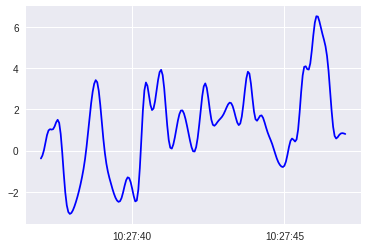

In [ ]:
 plt.plot(lab.t[0], lab.x[0],"b-") # after noise filter

In [ ]:
def generate(df, p = ["x","y","z"]): # body, gravity and jerk signal
  #tbody(highpass fc=0.1)
  for i in p:
    df["tbody-"+i] = df[i].apply(lambda x:filter(x,0.1,20,"highpass"))
  print ("tbody completed...")
  #tgravity(lowpass fc=0.1)
  for i in p:
    df["tgravity-"+i] = df[i].apply(lambda x:filter(x,0.1,20,"lowpass"))
  print ("tgravity completed...")
  #tjerk(np.gradient)
  for i in p:
    df["tbodyjerk-"+i] = df[i].apply(np.gradient)
  print ("jerk completed...")
  return df

In [ ]:
lab = generate (lab) # Generate body, gravity and jerk signal in time domain
lab.head(1)

tbody completed...
tgravity completed...
jerk completed...


,user_id,act_id,s,f,x,y,z,t,l,tbody-x,tbody-y,tbody-z,tgravity-x,tgravity-y,tgravity-z,tbodyjerk-x,tbodyjerk-y,tbodyjerk-z
0,4.0,5.0,2018-12-02 10:27:37+09:00,2018-12-02 10:27:47+09:00,"[-0.3845596805526592, -0.23867656781256547, 0....","[7.45114028317328, 7.447166507281951, 7.403008...","[6.128273660334606, 6.116058620396469, 6.09710...","[2018-12-02 10:27:37+09:00, 2018-12-02 10:27:3...",201,"[0.8965833803888579, 1.0252532096105793, 1.267...","[-1.2546814920805436, -1.2590830411810034, -1....","[1.7072431731848172, 1.7188445035535826, 1.724...","[-1.167092473913324, -1.1435399773010322, -1.1...","[8.686103866326775, 8.684696352979357, 8.68354...","[4.4564447292471865, 4.434187735532039, 4.4113...","[0.14588311274009375, 0.20259635267654497, 0.3...","[-0.00397377589132919, -0.024065932428872117, ...","[-0.012215039938136663, -0.015585991579891711,..."


In [ ]:
def mag(df, name ): # magnitude of a 3D signal--> l2 norm
  X =[]
  for i in range(len(df)):
    x = df.loc[i,name + "-x"]
    y = df.loc[i,name + "-y"]
    z = df.loc[i,name + "-z"]
    a = np.vstack([x,y,z])
    X.append(np.linalg.norm(a, axis = 0))
  df[name + "mag"] = X
  return df

In [ ]:
lab = mag(lab, "tbody") # magnitude of the tbody signal
lab.head(1)

,user_id,act_id,s,f,x,y,z,t,l,tbody-x,tbody-y,tbody-z,tgravity-x,tgravity-y,tgravity-z,tbodyjerk-x,tbodyjerk-y,tbodyjerk-z,tbodymag
0,4.0,5.0,2018-12-02 10:27:37+09:00,2018-12-02 10:27:47+09:00,"[-0.3845596805526592, -0.23867656781256547, 0....","[7.45114028317328, 7.447166507281951, 7.403008...","[6.128273660334606, 6.116058620396469, 6.09710...","[2018-12-02 10:27:37+09:00, 2018-12-02 10:27:3...",201,"[0.8965833803888579, 1.0252532096105793, 1.267...","[-1.2546814920805436, -1.2590830411810034, -1....","[1.7072431731848172, 1.7188445035535826, 1.724...","[-1.167092473913324, -1.1435399773010322, -1.1...","[8.686103866326775, 8.684696352979357, 8.68354...","[4.4564447292471865, 4.434187735532039, 4.4113...","[0.14588311274009375, 0.20259635267654497, 0.3...","[-0.00397377589132919, -0.024065932428872117, ...","[-0.012215039938136663, -0.015585991579891711,...","[2.3006013685436977, 2.36450009004076, 2.50585..."


In [ ]:
lab = mag(lab, "tgravity") # magnitude of the tgravity signal
lab.head(1)

,user_id,act_id,s,f,x,y,z,t,l,tbody-x,tbody-y,tbody-z,tgravity-x,tgravity-y,tgravity-z,tbodyjerk-x,tbodyjerk-y,tbodyjerk-z,tbodymag,tgravitymag
0,4.0,5.0,2018-12-02 10:27:37+09:00,2018-12-02 10:27:47+09:00,"[-0.3845596805526592, -0.23867656781256547, 0....","[7.45114028317328, 7.447166507281951, 7.403008...","[6.128273660334606, 6.116058620396469, 6.09710...","[2018-12-02 10:27:37+09:00, 2018-12-02 10:27:3...",201,"[0.8965833803888579, 1.0252532096105793, 1.267...","[-1.2546814920805436, -1.2590830411810034, -1....","[1.7072431731848172, 1.7188445035535826, 1.724...","[-1.167092473913324, -1.1435399773010322, -1.1...","[8.686103866326775, 8.684696352979357, 8.68354...","[4.4564447292471865, 4.434187735532039, 4.4113...","[0.14588311274009375, 0.20259635267654497, 0.3...","[-0.00397377589132919, -0.024065932428872117, ...","[-0.012215039938136663, -0.015585991579891711,...","[2.3006013685436977, 2.36450009004076, 2.50585...","[9.832110904791355, 9.818027057259586, 9.80399..."


In [ ]:
lab = mag(lab, "tbodyjerk") # magnitude of the tbodyjerk signal
lab.head(1)

,user_id,act_id,s,f,x,y,z,t,l,tbody-x,tbody-y,tbody-z,tgravity-x,tgravity-y,tgravity-z,tbodyjerk-x,tbodyjerk-y,tbodyjerk-z,tbodymag,tgravitymag,tbodyjerkmag
0,4.0,5.0,2018-12-02 10:27:37+09:00,2018-12-02 10:27:47+09:00,"[-0.3845596805526592, -0.23867656781256547, 0....","[7.45114028317328, 7.447166507281951, 7.403008...","[6.128273660334606, 6.116058620396469, 6.09710...","[2018-12-02 10:27:37+09:00, 2018-12-02 10:27:3...",201,"[0.8965833803888579, 1.0252532096105793, 1.267...","[-1.2546814920805436, -1.2590830411810034, -1....","[1.7072431731848172, 1.7188445035535826, 1.724...","[-1.167092473913324, -1.1435399773010322, -1.1...","[8.686103866326775, 8.684696352979357, 8.68354...","[4.4564447292471865, 4.434187735532039, 4.4113...","[0.14588311274009375, 0.20259635267654497, 0.3...","[-0.00397377589132919, -0.024065932428872117, ...","[-0.012215039938136663, -0.015585991579891711,...","[2.3006013685436977, 2.36450009004076, 2.50585...","[9.832110904791355, 9.818027057259586, 9.80399...","[0.14644753558275977, 0.20461518603231407, 0.3..."


In [ ]:
# fast fourier transform to analysis in the frequency domain
lab["fbody-x"] = lab["tbody-x"].apply(lambda x: np.abs(fftpack.fft(x))) 
lab["fbody-y"] = lab["tbody-y"].apply(lambda x: np.abs(fftpack.fft(x)))
lab["fbody-z"] = lab["tbody-z"].apply(lambda x: np.abs(fftpack.fft(x)))
lab.head(1)

,user_id,act_id,s,f,x,y,z,t,l,tbody-x,tbody-y,tbody-z,tgravity-x,tgravity-y,tgravity-z,tbodyjerk-x,tbodyjerk-y,tbodyjerk-z,tbodymag,tgravitymag,tbodyjerkmag,fbody-x,fbody-y,fbody-z
0,4.0,5.0,2018-12-02 10:27:37+09:00,2018-12-02 10:27:47+09:00,"[-0.3845596805526592, -0.23867656781256547, 0....","[7.45114028317328, 7.447166507281951, 7.403008...","[6.128273660334606, 6.116058620396469, 6.09710...","[2018-12-02 10:27:37+09:00, 2018-12-02 10:27:3...",201,"[0.8965833803888579, 1.0252532096105793, 1.267...","[-1.2546814920805436, -1.2590830411810034, -1....","[1.7072431731848172, 1.7188445035535826, 1.724...","[-1.167092473913324, -1.1435399773010322, -1.1...","[8.686103866326775, 8.684696352979357, 8.68354...","[4.4564447292471865, 4.434187735532039, 4.4113...","[0.14588311274009375, 0.20259635267654497, 0.3...","[-0.00397377589132919, -0.024065932428872117, ...","[-0.012215039938136663, -0.015585991579891711,...","[2.3006013685436977, 2.36450009004076, 2.50585...","[9.832110904791355, 9.818027057259586, 9.80399...","[0.14644753558275977, 0.20461518603231407, 0.3...","[2.858325667122296, 86.07940421077586, 121.475...","[6.1282576796513535, 31.527015605731947, 81.70...","[2.604569900696028, 23.60011959521943, 122.041..."


In [ ]:
# frequency domain jerk signal
lab["fbodyjerk-x"] = lab["fbody-x"].apply(np.gradient)
lab["fbodyjerk-y"] = lab["fbody-y"].apply(np.gradient)
lab["fbodyjerk-z"] = lab["fbody-z"].apply(np.gradient)
lab.head(1)

,user_id,act_id,s,f,x,y,z,t,l,tbody-x,tbody-y,tbody-z,tgravity-x,tgravity-y,tgravity-z,tbodyjerk-x,tbodyjerk-y,tbodyjerk-z,tbodymag,tgravitymag,tbodyjerkmag,fbody-x,fbody-y,fbody-z,fbodyjerk-x,fbodyjerk-y,fbodyjerk-z
0,4.0,5.0,2018-12-02 10:27:37+09:00,2018-12-02 10:27:47+09:00,"[-0.3845596805526592, -0.23867656781256547, 0....","[7.45114028317328, 7.447166507281951, 7.403008...","[6.128273660334606, 6.116058620396469, 6.09710...","[2018-12-02 10:27:37+09:00, 2018-12-02 10:27:3...",201,"[0.8965833803888579, 1.0252532096105793, 1.267...","[-1.2546814920805436, -1.2590830411810034, -1....","[1.7072431731848172, 1.7188445035535826, 1.724...","[-1.167092473913324, -1.1435399773010322, -1.1...","[8.686103866326775, 8.684696352979357, 8.68354...","[4.4564447292471865, 4.434187735532039, 4.4113...","[0.14588311274009375, 0.20259635267654497, 0.3...","[-0.00397377589132919, -0.024065932428872117, ...","[-0.012215039938136663, -0.015585991579891711,...","[2.3006013685436977, 2.36450009004076, 2.50585...","[9.832110904791355, 9.818027057259586, 9.80399...","[0.14644753558275977, 0.20461518603231407, 0.3...","[2.858325667122296, 86.07940421077586, 121.475...","[6.1282576796513535, 31.527015605731947, 81.70...","[2.604569900696028, 23.60011959521943, 122.041...","[83.22107854365356, 59.308591223231836, -15.47...","[25.39875792608059, 37.7907276892839, 10.35979...","[20.9955496945234, 59.71862776721141, 44.76325..."


In [ ]:
lab = mag(lab, "fbody") # magnitude of the fbody signal
lab.head(1)

,user_id,act_id,s,f,x,y,z,t,l,tbody-x,tbody-y,tbody-z,tgravity-x,tgravity-y,tgravity-z,tbodyjerk-x,tbodyjerk-y,tbodyjerk-z,tbodymag,tgravitymag,tbodyjerkmag,fbody-x,fbody-y,fbody-z,fbodyjerk-x,fbodyjerk-y,fbodyjerk-z,fbodymag
0,4.0,5.0,2018-12-02 10:27:37+09:00,2018-12-02 10:27:47+09:00,"[-0.3845596805526592, -0.23867656781256547, 0....","[7.45114028317328, 7.447166507281951, 7.403008...","[6.128273660334606, 6.116058620396469, 6.09710...","[2018-12-02 10:27:37+09:00, 2018-12-02 10:27:3...",201,"[0.8965833803888579, 1.0252532096105793, 1.267...","[-1.2546814920805436, -1.2590830411810034, -1....","[1.7072431731848172, 1.7188445035535826, 1.724...","[-1.167092473913324, -1.1435399773010322, -1.1...","[8.686103866326775, 8.684696352979357, 8.68354...","[4.4564447292471865, 4.434187735532039, 4.4113...","[0.14588311274009375, 0.20259635267654497, 0.3...","[-0.00397377589132919, -0.024065932428872117, ...","[-0.012215039938136663, -0.015585991579891711,...","[2.3006013685436977, 2.36450009004076, 2.50585...","[9.832110904791355, 9.818027057259586, 9.80399...","[0.14644753558275977, 0.20461518603231407, 0.3...","[2.858325667122296, 86.07940421077586, 121.475...","[6.1282576796513535, 31.527015605731947, 81.70...","[2.604569900696028, 23.60011959521943, 122.041...","[83.22107854365356, 59.308591223231836, -15.47...","[25.39875792608059, 37.7907276892839, 10.35979...","[20.9955496945234, 59.71862776721141, 44.76325...","[7.246333705754078, 94.66035171704605, 190.596..."


In [ ]:
lab = mag(lab, "fbodyjerk") # magnitude of the fbodyjerk signal
lab.head(1)

,user_id,act_id,s,f,x,y,z,t,l,tbody-x,tbody-y,tbody-z,tgravity-x,tgravity-y,tgravity-z,tbodyjerk-x,tbodyjerk-y,tbodyjerk-z,tbodymag,tgravitymag,tbodyjerkmag,fbody-x,fbody-y,fbody-z,fbodyjerk-x,fbodyjerk-y,fbodyjerk-z,fbodymag,fbodyjerkmag
0,4.0,5.0,2018-12-02 10:27:37+09:00,2018-12-02 10:27:47+09:00,"[-0.3845596805526592, -0.23867656781256547, 0....","[7.45114028317328, 7.447166507281951, 7.403008...","[6.128273660334606, 6.116058620396469, 6.09710...","[2018-12-02 10:27:37+09:00, 2018-12-02 10:27:3...",201,"[0.8965833803888579, 1.0252532096105793, 1.267...","[-1.2546814920805436, -1.2590830411810034, -1....","[1.7072431731848172, 1.7188445035535826, 1.724...","[-1.167092473913324, -1.1435399773010322, -1.1...","[8.686103866326775, 8.684696352979357, 8.68354...","[4.4564447292471865, 4.434187735532039, 4.4113...","[0.14588311274009375, 0.20259635267654497, 0.3...","[-0.00397377589132919, -0.024065932428872117, ...","[-0.012215039938136663, -0.015585991579891711,...","[2.3006013685436977, 2.36450009004076, 2.50585...","[9.832110904791355, 9.818027057259586, 9.80399...","[0.14644753558275977, 0.20461518603231407, 0.3...","[2.858325667122296, 86.07940421077586, 121.475...","[6.1282576796513535, 31.527015605731947, 81.70...","[2.604569900696028, 23.60011959521943, 122.041...","[83.22107854365356, 59.308591223231836, -15.47...","[25.39875792608059, 37.7907276892839, 10.35979...","[20.9955496945234, 59.71862776721141, 44.76325...","[7.246333705754078, 94.66035171704605, 190.596...","[89.50786515793904, 92.2602980407541, 48.48287..."


In [ ]:
# time domain features which use a single column ex. x/y/z
# total unique features are 9
def tfeature(df, var, p = ["-x","-y","-z"]): 
  for i in p:
    df[var+"mean"+i] = df[var + i].apply(np.mean)
    df[var+"std"+i] = df[var + i].apply(np.std)
    df[var+"mad"+i] = df[var + i].apply(lambda x: pd.Series(x).mad())
    df[var+"max"+i] = df[var + i].apply(np.max)
    df[var+"min"+i] = df[var + i].apply(np.min)
    df[var+"sum"+i] = df[var + i].apply(np.sum)
    df[var+"energy"+i] = df[var + i].apply(lambda x: np.sum(x**2)/len(x))
    df[var+"iqr"+i] = df[var + i].apply(scipy.stats.iqr)
    df[var+"entropy"+i] = df[var + i].apply(lambda x:scipy.stats.entropy((x-min(x))/(max(x)-min(x))))
    print ("completed: "+i)
  return df

In [ ]:
# Time domain signal which use two of three columns
# Total unique features are 4 
 def trest_feature(df,name): 
  sma = [] # sma --> signal magnitude area
  for i in range(len(df)):
    t = (df.t[i].max() - df.t[i].min())/pd.Timedelta("1s")
    sma.append((df[name + "-x"][i].sum()+df[name + "-y"][i].sum()+df[name + "-z"][i].sum())/t)
  df[name+"-"+"sma"] = sma
  print("completed sma")
  XY ,XZ, YZ= [],[],[]
  for i in range(len(df)): # pearson co-relation cofficient among two column
    XY.append(np.corrcoef(df[name + "-x"][i], df[name + "-y"][i])[0,1])
    XZ.append(np.corrcoef(df[name + "-x"][i], df[name + "-z"][i])[0,1])
    YZ.append(np.corrcoef(df[name + "-y"][i], df[name + "-z"][i])[0,1])
  print ("completed coef")
  df[name + "coef-xy"] = XY
  df[name + "coef-xz"] = XZ
  df[name + "coef-yz"] = YZ
  return df

In [ ]:
# totally compute the time domain features(single column)
lab = tfeature (lab, "tbody")
lab = tfeature (lab, "tgravity")
lab = tfeature (lab, "tbodyjerk")
lab.head(1)
# total --> 3*3*9 = 81

completed: -x
completed: -y
completed: -z
completed: -x
completed: -y
completed: -z
completed: -x
completed: -y
completed: -z


,user_id,act_id,s,f,x,y,z,t,l,tbody-x,tbody-y,tbody-z,tgravity-x,tgravity-y,tgravity-z,tbodyjerk-x,tbodyjerk-y,tbodyjerk-z,tbodymag,tgravitymag,tbodyjerkmag,fbody-x,fbody-y,fbody-z,fbodyjerk-x,fbodyjerk-y,fbodyjerk-z,fbodymag,fbodyjerkmag,tbodymean-x,tbodystd-x,tbodymad-x,tbodymax-x,tbodymin-x,tbodysum-x,tbodyenergy-x,tbodyiqr-x,tbodyentropy-x,tbodymean-y,tbodystd-y,tbodymad-y,tbodymax-y,tbodymin-y,tbodysum-y,tbodyenergy-y,tbodyiqr-y,tbodyentropy-y,tbodymean-z,tbodystd-z,tbodymad-z,tbodymax-z,tbodymin-z,tbodysum-z,tbodyenergy-z,tbodyiqr-z,tbodyentropy-z,tgravitymean-x,tgravitystd-x,tgravitymad-x,tgravitymax-x,tgravitymin-x,tgravitysum-x,tgravityenergy-x,tgravityiqr-x,tgravityentropy-x,tgravitymean-y,tgravitystd-y,tgravitymad-y,tgravitymax-y,tgravitymin-y,tgravitysum-y,tgravityenergy-y,tgravityiqr-y,tgravityentropy-y,tgravitymean-z,tgravitystd-z,tgravitymad-z,tgravitymax-z,tgravitymin-z,tgravitysum-z,tgravityenergy-z,tgravityiqr-z,tgravityentropy-z,tbodyjerkmean-x,tbodyjerkstd-x,tbodyjerkmad-x,tbodyjerkmax-x,tbodyjerkmin-x,tbodyjerksum-x,tbodyjerkenergy-x,tbodyjerkiqr-x,tbodyjerkentropy-x,tbodyjerkmean-y,tbodyjerkstd-y,tbodyjerkmad-y,tbodyjerkmax-y,tbodyjerkmin-y,tbodyjerksum-y,tbodyjerkenergy-y,tbodyjerkiqr-y,tbodyjerkentropy-y,tbodyjerkmean-z,tbodyjerkstd-z,tbodyjerkmad-z,tbodyjerkmax-z,tbodyjerkmin-z,tbodyjerksum-z,tbodyjerkenergy-z,tbodyjerkiqr-z,tbodyjerkentropy-z
0,4.0,5.0,2018-12-02 10:27:37+09:00,2018-12-02 10:27:47+09:00,"[-0.3845596805526592, -0.23867656781256547, 0....","[7.45114028317328, 7.447166507281951, 7.403008...","[6.128273660334606, 6.116058620396469, 6.09710...","[2018-12-02 10:27:37+09:00, 2018-12-02 10:27:3...",201,"[0.8965833803888579, 1.0252532096105793, 1.267...","[-1.2546814920805436, -1.2590830411810034, -1....","[1.7072431731848172, 1.7188445035535826, 1.724...","[-1.167092473913324, -1.1435399773010322, -1.1...","[8.686103866326775, 8.684696352979357, 8.68354...","[4.4564447292471865, 4.434187735532039, 4.4113...","[0.14588311274009375, 0.20259635267654497, 0.3...","[-0.00397377589132919, -0.024065932428872117, ...","[-0.012215039938136663, -0.015585991579891711,...","[2.3006013685436977, 2.36450009004076, 2.50585...","[9.832110904791355, 9.818027057259586, 9.80399...","[0.14644753558275977, 0.20461518603231407, 0.3...","[2.858325667122296, 86.07940421077586, 121.475...","[6.1282576796513535, 31.527015605731947, 81.70...","[2.604569900696028, 23.60011959521943, 122.041...","[83.22107854365356, 59.308591223231836, -15.47...","[25.39875792608059, 37.7907276892839, 10.35979...","[20.9955496945234, 59.71862776721141, 44.76325...","[7.246333705754078, 94.66035171704605, 190.596...","[89.50786515793904, 92.2602980407541, 48.48287...",-0.014221,1.979245,1.633754,4.008779,-4.166339,-2.858326,3.917612,2.91179,5.175806,-0.030489,1.066898,0.833236,1.996183,-3.096285,-6.128258,1.139202,1.202209,5.229263,-0.012958,1.621767,1.257239,3.814445,-3.08818,-2.60457,2.630297,1.889791,5.153577,0.958332,1.000486,0.873025,1.972119,-1.167092,192.62474,1.919373,1.719084,5.161197,9.072572,0.219598,0.195048,9.284458,8.681522,1823.587055,82.359794,0.403937,5.086126,1.701984,1.394991,1.228643,4.456445,0.218602,342.098705,4.842748,2.518215,4.808634,0.006206,0.421402,0.327325,1.391003,-0.971142,1.247422,0.177618,0.527431,5.198433,0.00695,0.292046,0.220079,0.684884,-0.932275,1.396947,0.085339,0.350143,5.248335,-0.034113,0.351075,0.223483,1.001086,-1.155705,-6.856616,0.124417,0.102074,5.246929


In [ ]:
# compute the time domain features(multiple columns)
lab = trest_feature (lab, "tbody")
lab = trest_feature (lab, "tgravity")
lab = trest_feature (lab, "tbodyjerk")
lab.head(1)
# total --> 3*1*4 = 12

completed sma
completed coef
completed sma
completed coef
completed sma


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


completed coef


,user_id,act_id,s,f,x,y,z,t,l,tbody-x,tbody-y,tbody-z,tgravity-x,tgravity-y,tgravity-z,tbodyjerk-x,tbodyjerk-y,tbodyjerk-z,tbodymag,tgravitymag,tbodyjerkmag,fbody-x,fbody-y,fbody-z,fbodyjerk-x,fbodyjerk-y,fbodyjerk-z,fbodymag,fbodyjerkmag,tbodymean-x,tbodystd-x,tbodymad-x,tbodymax-x,tbodymin-x,tbodysum-x,tbodyenergy-x,tbodyiqr-x,tbodyentropy-x,tbodymean-y,tbodystd-y,tbodymad-y,tbodymax-y,tbodymin-y,tbodysum-y,tbodyenergy-y,tbodyiqr-y,tbodyentropy-y,tbodymean-z,tbodystd-z,tbodymad-z,tbodymax-z,tbodymin-z,tbodysum-z,tbodyenergy-z,tbodyiqr-z,tbodyentropy-z,tgravitymean-x,tgravitystd-x,tgravitymad-x,tgravitymax-x,tgravitymin-x,tgravitysum-x,tgravityenergy-x,tgravityiqr-x,tgravityentropy-x,tgravitymean-y,tgravitystd-y,tgravitymad-y,tgravitymax-y,tgravitymin-y,tgravitysum-y,tgravityenergy-y,tgravityiqr-y,tgravityentropy-y,tgravitymean-z,tgravitystd-z,tgravitymad-z,tgravitymax-z,tgravitymin-z,tgravitysum-z,tgravityenergy-z,tgravityiqr-z,tgravityentropy-z,tbodyjerkmean-x,tbodyjerkstd-x,tbodyjerkmad-x,tbodyjerkmax-x,tbodyjerkmin-x,tbodyjerksum-x,tbodyjerkenergy-x,tbodyjerkiqr-x,tbodyjerkentropy-x,tbodyjerkmean-y,tbodyjerkstd-y,tbodyjerkmad-y,tbodyjerkmax-y,tbodyjerkmin-y,tbodyjerksum-y,tbodyjerkenergy-y,tbodyjerkiqr-y,tbodyjerkentropy-y,tbodyjerkmean-z,tbodyjerkstd-z,tbodyjerkmad-z,tbodyjerkmax-z,tbodyjerkmin-z,tbodyjerksum-z,tbodyjerkenergy-z,tbodyjerkiqr-z,tbodyjerkentropy-z,tbody-sma,tbodycoef-xy,tbodycoef-xz,tbodycoef-yz,tgravity-sma,tgravitycoef-xy,tgravitycoef-xz,tgravitycoef-yz,tbodyjerk-sma,tbodyjerkcoef-xy,tbodyjerkcoef-xz,tbodyjerkcoef-yz
0,4.0,5.0,2018-12-02 10:27:37+09:00,2018-12-02 10:27:47+09:00,"[-0.3845596805526592, -0.23867656781256547, 0....","[7.45114028317328, 7.447166507281951, 7.403008...","[6.128273660334606, 6.116058620396469, 6.09710...","[2018-12-02 10:27:37+09:00, 2018-12-02 10:27:3...",201,"[0.8965833803888579, 1.0252532096105793, 1.267...","[-1.2546814920805436, -1.2590830411810034, -1....","[1.7072431731848172, 1.7188445035535826, 1.724...","[-1.167092473913324, -1.1435399773010322, -1.1...","[8.686103866326775, 8.684696352979357, 8.68354...","[4.4564447292471865, 4.434187735532039, 4.4113...","[0.14588311274009375, 0.20259635267654497, 0.3...","[-0.00397377589132919, -0.024065932428872117, ...","[-0.012215039938136663, -0.015585991579891711,...","[2.3006013685436977, 2.36450009004076, 2.50585...","[9.832110904791355, 9.818027057259586, 9.80399...","[0.14644753558275977, 0.20461518603231407, 0.3...","[2.858325667122296, 86.07940421077586, 121.475...","[6.1282576796513535, 31.527015605731947, 81.70...","[2.604569900696028, 23.60011959521943, 122.041...","[83.22107854365356, 59.308591223231836, -15.47...","[25.39875792608059, 37.7907276892839, 10.35979...","[20.9955496945234, 59.71862776721141, 44.76325...","[7.246333705754078, 94.66035171704605, 190.596...","[89.50786515793904, 92.2602980407541, 48.48287...",-0.014221,1.979245,1.633754,4.008779,-4.166339,-2.858326,3.917612,2.91179,5.175806,-0.030489,1.066898,0.833236,1.996183,-3.096285,-6.128258,1.139202,1.202209,5.229263,-0.012958,1.621767,1.257239,3.814445,-3.08818,-2.60457,2.630297,1.889791,5.153577,0.958332,1.000486,0.873025,1.972119,-1.167092,192.62474,1.919373,1.719084,5.161197,9.072572,0.219598,0.195048,9.284458,8.681522,1823.587055,82.359794,0.403937,5.086126,1.701984,1.394991,1.228643,4.456445,0.218602,342.098705,4.842748,2.518215,4.808634,0.006206,0.421402,0.327325,1.391003,-0.971142,1.247422,0.177618,0.527431,5.198433,0.00695,0.292046,0.220079,0.684884,-0.932275,1.396947,0.085339,0.350143,5.248335,-0.034113,0.351075,0.223483,1.001086,-1.155705,-6.856616,0.124417,0.102074,5.246929,-1.159115,-0.262828,0.493321,-0.453791,235.83105,0.996831,-0.998323,-0.996634,-0.421225,0.139665,0.397624,0.002909


In [ ]:
# magnitude columns have only one property mag, not x/y/z
lab = tfeature (lab, "tbodymag", [""])
lab = tfeature (lab, "tgravitymag", [""])
lab = tfeature (lab, "tbodyjerkmag", [""])
lab.head(1)  
# total --> 3*1*9 = 27

completed: 
completed: 
completed: 


,user_id,act_id,s,f,x,y,z,t,l,tbody-x,tbody-y,tbody-z,tgravity-x,tgravity-y,tgravity-z,tbodyjerk-x,tbodyjerk-y,tbodyjerk-z,tbodymag,tgravitymag,tbodyjerkmag,fbody-x,fbody-y,fbody-z,fbodyjerk-x,fbodyjerk-y,fbodyjerk-z,fbodymag,fbodyjerkmag,tbodymean-x,tbodystd-x,tbodymad-x,tbodymax-x,tbodymin-x,tbodysum-x,tbodyenergy-x,tbodyiqr-x,tbodyentropy-x,tbodymean-y,tbodystd-y,tbodymad-y,tbodymax-y,tbodymin-y,tbodysum-y,tbodyenergy-y,tbodyiqr-y,tbodyentropy-y,tbodymean-z,tbodystd-z,tbodymad-z,tbodymax-z,tbodymin-z,tbodysum-z,tbodyenergy-z,tbodyiqr-z,tbodyentropy-z,tgravitymean-x,tgravitystd-x,tgravitymad-x,tgravitymax-x,tgravitymin-x,tgravitysum-x,tgravityenergy-x,tgravityiqr-x,tgravityentropy-x,tgravitymean-y,tgravitystd-y,tgravitymad-y,tgravitymax-y,tgravitymin-y,tgravitysum-y,tgravityenergy-y,tgravityiqr-y,tgravityentropy-y,tgravitymean-z,tgravitystd-z,tgravitymad-z,tgravitymax-z,tgravitymin-z,tgravitysum-z,tgravityenergy-z,tgravityiqr-z,tgravityentropy-z,tbodyjerkmean-x,tbodyjerkstd-x,tbodyjerkmad-x,tbodyjerkmax-x,tbodyjerkmin-x,tbodyjerksum-x,tbodyjerkenergy-x,tbodyjerkiqr-x,tbodyjerkentropy-x,tbodyjerkmean-y,tbodyjerkstd-y,tbodyjerkmad-y,tbodyjerkmax-y,tbodyjerkmin-y,tbodyjerksum-y,tbodyjerkenergy-y,tbodyjerkiqr-y,tbodyjerkentropy-y,tbodyjerkmean-z,tbodyjerkstd-z,tbodyjerkmad-z,tbodyjerkmax-z,tbodyjerkmin-z,tbodyjerksum-z,tbodyjerkenergy-z,tbodyjerkiqr-z,tbodyjerkentropy-z,tbody-sma,tbodycoef-xy,tbodycoef-xz,tbodycoef-yz,tgravity-sma,tgravitycoef-xy,tgravitycoef-xz,tgravitycoef-yz,tbodyjerk-sma,tbodyjerkcoef-xy,tbodyjerkcoef-xz,tbodyjerkcoef-yz,tbodymagmean,tbodymagstd,tbodymagmad,tbodymagmax,tbodymagmin,tbodymagsum,tbodymagenergy,tbodymagiqr,tbodymagentropy,tgravitymagmean,tgravitymagstd,tgravitymagmad,tgravitymagmax,tgravitymagmin,tgravitymagsum,tgravitymagenergy,tgravitymagiqr,tgravitymagentropy,tbodyjerkmagmean,tbodyjerkmagstd,tbodyjerkmagmad,tbodyjerkmagmax,tbodyjerkmagmin,tbodyjerkmagsum,tbodyjerkmagenergy,tbodyjerkmagiqr,tbodyjerkmagentropy
0,4.0,5.0,2018-12-02 10:27:37+09:00,2018-12-02 10:27:47+09:00,"[-0.3845596805526592, -0.23867656781256547, 0....","[7.45114028317328, 7.447166507281951, 7.403008...","[6.128273660334606, 6.116058620396469, 6.09710...","[2018-12-02 10:27:37+09:00, 2018-12-02 10:27:3...",201,"[0.8965833803888579, 1.0252532096105793, 1.267...","[-1.2546814920805436, -1.2590830411810034, -1....","[1.7072431731848172, 1.7188445035535826, 1.724...","[-1.167092473913324, -1.1435399773010322, -1.1...","[8.686103866326775, 8.684696352979357, 8.68354...","[4.4564447292471865, 4.434187735532039, 4.4113...","[0.14588311274009375, 0.20259635267654497, 0.3...","[-0.00397377589132919, -0.024065932428872117, ...","[-0.012215039938136663, -0.015585991579891711,...","[2.3006013685436977, 2.36450009004076, 2.50585...","[9.832110904791355, 9.818027057259586, 9.80399...","[0.14644753558275977, 0.20461518603231407, 0.3...","[2.858325667122296, 86.07940421077586, 121.475...","[6.1282576796513535, 31.527015605731947, 81.70...","[2.604569900696028, 23.60011959521943, 122.041...","[83.22107854365356, 59.308591223231836, -15.47...","[25.39875792608059, 37.7907276892839, 10.35979...","[20.9955496945234, 59.71862776721141, 44.76325...","[7.246333705754078, 94.66035171704605, 190.596...","[89.50786515793904, 92.2602980407541, 48.48287...",-0.014221,1.979245,1.633754,4.008779,-4.166339,-2.858326,3.917612,2.91179,5.175806,-0.030489,1.066898,0.833236,1.996183,-3.096285,-6.128258,1.139202,1.202209,5.229263,-0.012958,1.621767,1.257239,3.814445,-3.08818,-2.60457,2.630297,1.889791,5.153577,0.958332,1.000486,0.873025,1.972119,-1.167092,192.62474,1.919373,1.719084,5.161197,9.072572,0.219598,0.195048,9.284458,8.681522,1823.587055,82.359794,0.403937,5.086126,1.701984,1.394991,1.228643,4.456445,0.218602,342.098705,4.842748,2.518215,4.808634,0.006206,0.421402,0.327325,1.391003,-0.971142,1.247422,0.177618,0.527431,5.198433,0.00695,0.292046,0.220079,0.684884,-0.932275,1.396947,0.085339,0.350143,5.248335,-0.034113,0.351075,0.223483,1.001086,-1.155705

In [ ]:
 # Frequency domain all features
 # total frequency domain features are 12
 def ffeature(df, var, p = ["-x","-y","-z"]): 
  for i in p:
    df[var+"mean"+i] = df[var + i].apply(np.mean)
    df[var+"std"+i] = df[var + i].apply(np.std)
    df[var+"mad"+i] = df[var + i].apply(lambda x: pd.Series(x).mad())
    df[var+"max"+i] = df[var + i].apply(np.max)
    df[var+"min"+i] = df[var + i].apply(np.min)
    df[var+"sum"+i] = df[var + i].apply(np.sum)
    df[var+"energy"+i] = df[var + i].apply(lambda x: np.sum(x**2)/len(x))
    df[var+"iqr"+i] = df[var + i].apply(scipy.stats.iqr)
    df[var+"entropy"+i] = df[var + i].apply(lambda x:scipy.stats.entropy((x-min(x))/(max(x)-min(x))))
    df[var+"skewness" +i] = df[var +i].apply(scipy.stats.skew)
    df[var+"kurtosis" +i] = df[var +i].apply(scipy.stats.kurtosis)
    df[var+"maxInds" + i] = df[var +i].apply(lambda x:np.where(x == np.max(x))[0][0])
  return df

In [ ]:
# total frequency doamin features
lab = ffeature (lab, "fbody")
lab = ffeature (lab, "fbodyjerk")
lab = ffeature (lab, "fbodymag", [""])
lab = ffeature (lab, "fbodyjerkmag", [""])
lab.head(1)
# total --> 2*3*12 + 2*1*12 = 96

,user_id,act_id,s,f,x,y,z,t,l,tbody-x,tbody-y,tbody-z,tgravity-x,tgravity-y,tgravity-z,tbodyjerk-x,tbodyjerk-y,tbodyjerk-z,tbodymag,tgravitymag,tbodyjerkmag,fbody-x,fbody-y,fbody-z,fbodyjerk-x,fbodyjerk-y,fbodyjerk-z,fbodymag,fbodyjerkmag,tbodymean-x,tbodystd-x,tbodymad-x,tbodymax-x,tbodymin-x,tbodysum-x,tbodyenergy-x,tbodyiqr-x,tbodyentropy-x,tbodymean-y,tbodystd-y,tbodymad-y,tbodymax-y,tbodymin-y,tbodysum-y,tbodyenergy-y,tbodyiqr-y,tbodyentropy-y,tbodymean-z,tbodystd-z,tbodymad-z,tbodymax-z,tbodymin-z,tbodysum-z,tbodyenergy-z,tbodyiqr-z,tbodyentropy-z,tgravitymean-x,tgravitystd-x,tgravitymad-x,tgravitymax-x,tgravitymin-x,tgravitysum-x,tgravityenergy-x,tgravityiqr-x,tgravityentropy-x,tgravitymean-y,tgravitystd-y,tgravitymad-y,tgravitymax-y,tgravitymin-y,tgravitysum-y,tgravityenergy-y,tgravityiqr-y,tgravityentropy-y,tgravitymean-z,tgravitystd-z,tgravitymad-z,tgravitymax-z,tgravitymin-z,tgravitysum-z,tgravityenergy-z,tgravityiqr-z,tgravityentropy-z,tbodyjerkmean-x,tbodyjerkstd-x,tbodyjerkmad-x,tbodyjerkmax-x,tbodyjerkmin-x,tbodyjerksum-x,tbodyjerkenergy-x,tbodyjerkiqr-x,tbodyjerkentropy-x,tbodyjerkmean-y,tbodyjerkstd-y,tbodyjerkmad-y,tbodyjerkmax-y,tbodyjerkmin-y,tbodyjerksum-y,tbodyjerkenergy-y,tbodyjerkiqr-y,tbodyjerkentropy-y,tbodyjerkmean-z,tbodyjerkstd-z,tbodyjerkmad-z,tbodyjerkmax-z,tbodyjerkmin-z,tbodyjerksum-z,tbodyjerkenergy-z,tbodyjerkiqr-z,tbodyjerkentropy-z,tbody-sma,tbodycoef-xy,tbodycoef-xz,tbodycoef-yz,tgravity-sma,tgravitycoef-xy,tgravitycoef-xz,tgravitycoef-yz,tbodyjerk-sma,tbodyjerkcoef-xy,tbodyjerkcoef-xz,tbodyjerkcoef-yz,tbodymagmean,tbodymagstd,tbodymagmad,tbodymagmax,tbodymagmin,tbodymagsum,tbodymagenergy,tbodymagiqr,tbodymagentropy,tgravitymagmean,tgravitymagstd,tgravitymagmad,tgravitymagmax,tgravitymagmin,tgravitymagsum,tgravitymagenergy,tgravitymagiqr,tgravitymagentropy,tbodyjerkmagmean,tbodyjerkmagstd,tbodyjerkmagmad,tbodyjerkmagmax,tbodyjerkmagmin,tbodyjerkmagsum,tbodyjerkmagenergy,tbodyjerkmagiqr,tbodyjerkmagentropy,fbodymean-x,fbodystd-x,fbodymad-x,fbodymax-x,fbodymin-x,fbodysum-x,fbodyenergy-x,fbodyiqr-x,fbodyentropy-x,fbodyskewness-x,fbodykurtosis-x,fbodymaxInds-x,fbodymean-y,fbodystd-y,fbodymad-y,fbodymax-y,fbodymin-y,fbodysum-y,fbodyenergy-y,fbodyiqr-y,fbodyentropy-y,fbodyskewness-y,fbodykurtosis-y,fbodymaxInds-y,fbodymean-z,fbodystd-z,fbodymad-z,fbodymax-z,fbodymin-z,fbodysum-z,fbodyenergy-z,fbodyiqr-z,fbodyentropy-z,fbodyskewness-z,fbodykurtosis-z,fbodymaxInds-z,fbodyjerkmean-x,fbodyjerkstd-x,fbodyjerkmad-x,fbodyjerkmax-x,fbodyjerkmin-x,fbodyjerksum-x,fbodyjerkenergy-x,fbodyjerkiqr-x,fbodyjerkentropy-x,fbodyjerkskewness-x,fbodyjerkkurtosis-x,fbodyjerkmaxInds-x,fbodyjerkmean-y,fbodyjerkstd-y,fbodyjerkmad-y,fbodyjerkmax-y,fbodyjerkmin-y,fbodyjerksum-y,fbodyjerkenergy-y,fbodyjerkiqr-y,fbodyjerkentropy-y,fbodyjerkskewness-y,fbodyjerkkurtosis-y,fbodyjerkmaxInds-y,fbodyjerkmean-z,fbodyjerkstd-z,fbodyjerkmad-z,fbodyjerkmax-z,fbodyjerkmin-z,fbodyjerksum-z,fbodyjerkenergy-z,fbodyjerkiqr-z,fbodyjerkentropy-z,fbodyjerkskewness-z,fbodyjerkkurtosis-z,fbodyjerkmaxInds-z,fbodymagmean,fbodymagstd,fbodymagmad,fbodymagmax,fbodymagmin,fbodymagsum,fbodymagenergy,fbodymagiqr,fbodymagentropy,fbodymagskewness,fbodymagkurtosis,fbodymagmaxInds,fbodyjerkmagmean,fbodyjerkmagstd,fbodyjerkmagmad,fbodyjerkmagmax,fbodyjerkmagmin,fbodyjerkmagsum,fbodyjerkmagenergy,fbodyjerkmagiqr,fbodyjerkmagentropy,fbodyjerkmagskewness,fbodyjerkmagkurtosis,fbodyjerkmagmaxInds
0,4.0,5.0,2018-12-02 10:27:37+09:00,2018-12-02 10:27:47+09:00,"[-0.3845596805526592, -0.23867656781256547, 0....","[7.45114028317328, 7.447166507281951, 7.403008...","[6.128273660334606, 6.116058620396469, 6.09710...","[2018-12-02 10:27:37+09:00, 2018-12-02 10:27:3...",201,"[0.8965833803888579, 1.0252532096105793, 1.267...","[-1.2546814920805436, -1.2590830411810034, -1....","[1.7072431731848172, 1.7188445035535826, 1.724...","[-1.167092473913324, -1.1435399773010322, -1.1...","[8.686103866326775, 8.684696352979357, 8.68354...","[4.4564447292471865, 4.434187735532039, 

In [ ]:
# compute sma and coef
lab = trest_feature (lab, "fbody")
lab = trest_feature (lab, "fbodyjerk")
lab.head(1)
# total 2*1*4 = 8

completed sma
completed coef
completed sma
completed coef


,user_id,act_id,s,f,x,y,z,t,l,tbody-x,tbody-y,tbody-z,tgravity-x,tgravity-y,tgravity-z,tbodyjerk-x,tbodyjerk-y,tbodyjerk-z,tbodymag,tgravitymag,tbodyjerkmag,fbody-x,fbody-y,fbody-z,fbodyjerk-x,fbodyjerk-y,fbodyjerk-z,fbodymag,fbodyjerkmag,tbodymean-x,tbodystd-x,tbodymad-x,tbodymax-x,tbodymin-x,tbodysum-x,tbodyenergy-x,tbodyiqr-x,tbodyentropy-x,tbodymean-y,tbodystd-y,tbodymad-y,tbodymax-y,tbodymin-y,tbodysum-y,tbodyenergy-y,tbodyiqr-y,tbodyentropy-y,tbodymean-z,tbodystd-z,tbodymad-z,tbodymax-z,tbodymin-z,tbodysum-z,tbodyenergy-z,tbodyiqr-z,tbodyentropy-z,tgravitymean-x,tgravitystd-x,tgravitymad-x,tgravitymax-x,tgravitymin-x,tgravitysum-x,tgravityenergy-x,tgravityiqr-x,tgravityentropy-x,tgravitymean-y,tgravitystd-y,tgravitymad-y,tgravitymax-y,tgravitymin-y,tgravitysum-y,tgravityenergy-y,tgravityiqr-y,tgravityentropy-y,tgravitymean-z,tgravitystd-z,tgravitymad-z,tgravitymax-z,tgravitymin-z,tgravitysum-z,tgravityenergy-z,tgravityiqr-z,tgravityentropy-z,tbodyjerkmean-x,tbodyjerkstd-x,tbodyjerkmad-x,tbodyjerkmax-x,tbodyjerkmin-x,tbodyjerksum-x,tbodyjerkenergy-x,tbodyjerkiqr-x,tbodyjerkentropy-x,tbodyjerkmean-y,tbodyjerkstd-y,tbodyjerkmad-y,tbodyjerkmax-y,tbodyjerkmin-y,tbodyjerksum-y,tbodyjerkenergy-y,tbodyjerkiqr-y,tbodyjerkentropy-y,tbodyjerkmean-z,tbodyjerkstd-z,tbodyjerkmad-z,tbodyjerkmax-z,tbodyjerkmin-z,tbodyjerksum-z,tbodyjerkenergy-z,tbodyjerkiqr-z,tbodyjerkentropy-z,tbody-sma,tbodycoef-xy,tbodycoef-xz,tbodycoef-yz,tgravity-sma,tgravitycoef-xy,tgravitycoef-xz,tgravitycoef-yz,tbodyjerk-sma,tbodyjerkcoef-xy,tbodyjerkcoef-xz,tbodyjerkcoef-yz,tbodymagmean,tbodymagstd,tbodymagmad,tbodymagmax,tbodymagmin,tbodymagsum,tbodymagenergy,tbodymagiqr,tbodymagentropy,tgravitymagmean,tgravitymagstd,tgravitymagmad,tgravitymagmax,tgravitymagmin,tgravitymagsum,tgravitymagenergy,tgravitymagiqr,tgravitymagentropy,tbodyjerkmagmean,tbodyjerkmagstd,tbodyjerkmagmad,tbodyjerkmagmax,tbodyjerkmagmin,tbodyjerkmagsum,tbodyjerkmagenergy,tbodyjerkmagiqr,tbodyjerkmagentropy,fbodymean-x,fbodystd-x,fbodymad-x,fbodymax-x,fbodymin-x,fbodysum-x,fbodyenergy-x,fbodyiqr-x,fbodyentropy-x,fbodyskewness-x,fbodykurtosis-x,fbodymaxInds-x,fbodymean-y,fbodystd-y,fbodymad-y,fbodymax-y,fbodymin-y,fbodysum-y,fbodyenergy-y,fbodyiqr-y,fbodyentropy-y,fbodyskewness-y,fbodykurtosis-y,fbodymaxInds-y,fbodymean-z,fbodystd-z,fbodymad-z,fbodymax-z,fbodymin-z,fbodysum-z,fbodyenergy-z,fbodyiqr-z,fbodyentropy-z,fbodyskewness-z,fbodykurtosis-z,fbodymaxInds-z,fbodyjerkmean-x,fbodyjerkstd-x,fbodyjerkmad-x,fbodyjerkmax-x,fbodyjerkmin-x,fbodyjerksum-x,fbodyjerkenergy-x,fbodyjerkiqr-x,fbodyjerkentropy-x,fbodyjerkskewness-x,fbodyjerkkurtosis-x,fbodyjerkmaxInds-x,fbodyjerkmean-y,fbodyjerkstd-y,fbodyjerkmad-y,fbodyjerkmax-y,fbodyjerkmin-y,fbodyjerksum-y,fbodyjerkenergy-y,fbodyjerkiqr-y,fbodyjerkentropy-y,fbodyjerkskewness-y,fbodyjerkkurtosis-y,fbodyjerkmaxInds-y,fbodyjerkmean-z,fbodyjerkstd-z,fbodyjerkmad-z,fbodyjerkmax-z,fbodyjerkmin-z,fbodyjerksum-z,fbodyjerkenergy-z,fbodyjerkiqr-z,fbodyjerkentropy-z,fbodyjerkskewness-z,fbodyjerkkurtosis-z,fbodyjerkmaxInds-z,fbodymagmean,fbodymagstd,fbodymagmad,fbodymagmax,fbodymagmin,fbodymagsum,fbodymagenergy,fbodymagiqr,fbodymagentropy,fbodymagskewness,fbodymagkurtosis,fbodymagmaxInds,fbodyjerkmagmean,fbodyjerkmagstd,fbodyjerkmagmad,fbodyjerkmagmax,fbodyjerkmagmin,fbodyjerkmagsum,fbodyjerkmagenergy,fbodyjerkmagiqr,fbodyjerkmagentropy,fbodyjerkmagskewness,fbodyjerkmagkurtosis,fbodyjerkmagmaxInds,fbody-sma,fbodycoef-xy,fbodycoef-xz,fbodycoef-yz,fbodyjerk-sma,fbodyjerkcoef-xy,fbodyjerkcoef-xz,fbodyjerkcoef-yz
0,4.0,5.0,2018-12-02 10:27:37+09:00,2018-12-02 10:27:47+09:00,"[-0.3845596805526592, -0.23867656781256547, 0....","[7.45114028317328, 7.447166507281951, 7.403008...","[6.128273660334606, 6.116058620396469, 6.09710...","[2018-12-02 10:27:37+09:00, 2018-12-02 10:27:3...",201,"[0.8965833803888579, 1.0252532096105793, 1.267...","[-1.2546814920805436, -1.2590830411810034, -1....","[1.7072431731848172, 1.7188445035535826, 1.724...","[-1.167092473913324, -1.143539

In [ ]:
lab.shape #total shape

(84223, 253)

In [ ]:
c = lab.columns # total columns
c

Index(['user_id', 'act_id', 's', 'f', 'x', 'y', 'z', 't', 'l', 'tbody-x',
       ...
       'fbodyjerkmagkurtosis', 'fbodyjerkmagmaxInds', 'fbody-sma',
       'fbodycoef-xy', 'fbodycoef-xz', 'fbodycoef-yz', 'fbodyjerk-sma',
       'fbodyjerkcoef-xy', 'fbodyjerkcoef-xz', 'fbodyjerkcoef-yz'],
      dtype='object', length=253)

In [ ]:
c [2:29] # raw signal columns, need to be dropped

Index(['s', 'f', 'x', 'y', 'z', 't', 'l', 'tbody-x', 'tbody-y', 'tbody-z',
       'tgravity-x', 'tgravity-y', 'tgravity-z', 'tbodyjerk-x', 'tbodyjerk-y',
       'tbodyjerk-z', 'tbodymag', 'tgravitymag', 'tbodyjerkmag', 'fbody-x',
       'fbody-y', 'fbody-z', 'fbodyjerk-x', 'fbodyjerk-y', 'fbodyjerk-z',
       'fbodymag', 'fbodyjerkmag'],
      dtype='object')

In [ ]:
clab = lab.copy()

In [ ]:
clab.drop(columns = clab.columns[2:29], inplace = True)
clab.head(1)

,user_id,act_id,tbodymean-x,tbodystd-x,tbodymad-x,tbodymax-x,tbodymin-x,tbodysum-x,tbodyenergy-x,tbodyiqr-x,tbodyentropy-x,tbodymean-y,tbodystd-y,tbodymad-y,tbodymax-y,tbodymin-y,tbodysum-y,tbodyenergy-y,tbodyiqr-y,tbodyentropy-y,tbodymean-z,tbodystd-z,tbodymad-z,tbodymax-z,tbodymin-z,tbodysum-z,tbodyenergy-z,tbodyiqr-z,tbodyentropy-z,tgravitymean-x,tgravitystd-x,tgravitymad-x,tgravitymax-x,tgravitymin-x,tgravitysum-x,tgravityenergy-x,tgravityiqr-x,tgravityentropy-x,tgravitymean-y,tgravitystd-y,tgravitymad-y,tgravitymax-y,tgravitymin-y,tgravitysum-y,tgravityenergy-y,tgravityiqr-y,tgravityentropy-y,tgravitymean-z,tgravitystd-z,tgravitymad-z,tgravitymax-z,tgravitymin-z,tgravitysum-z,tgravityenergy-z,tgravityiqr-z,tgravityentropy-z,tbodyjerkmean-x,tbodyjerkstd-x,tbodyjerkmad-x,tbodyjerkmax-x,tbodyjerkmin-x,tbodyjerksum-x,tbodyjerkenergy-x,tbodyjerkiqr-x,tbodyjerkentropy-x,tbodyjerkmean-y,tbodyjerkstd-y,tbodyjerkmad-y,tbodyjerkmax-y,tbodyjerkmin-y,tbodyjerksum-y,tbodyjerkenergy-y,tbodyjerkiqr-y,tbodyjerkentropy-y,tbodyjerkmean-z,tbodyjerkstd-z,tbodyjerkmad-z,tbodyjerkmax-z,tbodyjerkmin-z,tbodyjerksum-z,tbodyjerkenergy-z,tbodyjerkiqr-z,tbodyjerkentropy-z,tbody-sma,tbodycoef-xy,tbodycoef-xz,tbodycoef-yz,tgravity-sma,tgravitycoef-xy,tgravitycoef-xz,tgravitycoef-yz,tbodyjerk-sma,tbodyjerkcoef-xy,tbodyjerkcoef-xz,tbodyjerkcoef-yz,tbodymagmean,tbodymagstd,tbodymagmad,tbodymagmax,tbodymagmin,tbodymagsum,tbodymagenergy,tbodymagiqr,tbodymagentropy,tgravitymagmean,tgravitymagstd,tgravitymagmad,tgravitymagmax,tgravitymagmin,tgravitymagsum,tgravitymagenergy,tgravitymagiqr,tgravitymagentropy,tbodyjerkmagmean,tbodyjerkmagstd,tbodyjerkmagmad,tbodyjerkmagmax,tbodyjerkmagmin,tbodyjerkmagsum,tbodyjerkmagenergy,tbodyjerkmagiqr,tbodyjerkmagentropy,fbodymean-x,fbodystd-x,fbodymad-x,fbodymax-x,fbodymin-x,fbodysum-x,fbodyenergy-x,fbodyiqr-x,fbodyentropy-x,fbodyskewness-x,fbodykurtosis-x,fbodymaxInds-x,fbodymean-y,fbodystd-y,fbodymad-y,fbodymax-y,fbodymin-y,fbodysum-y,fbodyenergy-y,fbodyiqr-y,fbodyentropy-y,fbodyskewness-y,fbodykurtosis-y,fbodymaxInds-y,fbodymean-z,fbodystd-z,fbodymad-z,fbodymax-z,fbodymin-z,fbodysum-z,fbodyenergy-z,fbodyiqr-z,fbodyentropy-z,fbodyskewness-z,fbodykurtosis-z,fbodymaxInds-z,fbodyjerkmean-x,fbodyjerkstd-x,fbodyjerkmad-x,fbodyjerkmax-x,fbodyjerkmin-x,fbodyjerksum-x,fbodyjerkenergy-x,fbodyjerkiqr-x,fbodyjerkentropy-x,fbodyjerkskewness-x,fbodyjerkkurtosis-x,fbodyjerkmaxInds-x,fbodyjerkmean-y,fbodyjerkstd-y,fbodyjerkmad-y,fbodyjerkmax-y,fbodyjerkmin-y,fbodyjerksum-y,fbodyjerkenergy-y,fbodyjerkiqr-y,fbodyjerkentropy-y,fbodyjerkskewness-y,fbodyjerkkurtosis-y,fbodyjerkmaxInds-y,fbodyjerkmean-z,fbodyjerkstd-z,fbodyjerkmad-z,fbodyjerkmax-z,fbodyjerkmin-z,fbodyjerksum-z,fbodyjerkenergy-z,fbodyjerkiqr-z,fbodyjerkentropy-z,fbodyjerkskewness-z,fbodyjerkkurtosis-z,fbodyjerkmaxInds-z,fbodymagmean,fbodymagstd,fbodymagmad,fbodymagmax,fbodymagmin,fbodymagsum,fbodymagenergy,fbodymagiqr,fbodymagentropy,fbodymagskewness,fbodymagkurtosis,fbodymagmaxInds,fbodyjerkmagmean,fbodyjerkmagstd,fbodyjerkmagmad,fbodyjerkmagmax,fbodyjerkmagmin,fbodyjerkmagsum,fbodyjerkmagenergy,fbodyjerkmagiqr,fbodyjerkmagentropy,fbodyjerkmagskewness,fbodyjerkmagkurtosis,fbodyjerkmagmaxInds,fbody-sma,fbodycoef-xy,fbodycoef-xz,fbodycoef-yz,fbodyjerk-sma,fbodyjerkcoef-xy,fbodyjerkcoef-xz,fbodyjerkcoef-yz
0,4.0,5.0,-0.014221,1.979245,1.633754,4.008779,-4.166339,-2.858326,3.917612,2.91179,5.175806,-0.030489,1.066898,0.833236,1.996183,-3.096285,-6.128258,1.139202,1.202209,5.229263,-0.012958,1.621767,1.257239,3.814445,-3.08818,-2.60457,2.630297,1.889791,5.153577,0.958332,1.000486,0.873025,1.972119,-1.167092,192.62474,1.919373,1.719084,5.161197,9.072572,0.219598,0.195048,9.284458,8.681522,1823.587055,82.359794,0.403937,5.086126,1.701984,1.394991,1.228643,4.456445,0.218602,342.098705,4.842748,2.518215,4.808634,0.006206,0.421402,0.327325,1.391003,-0.971142,1.247422,0.177618,0.527431,5.198433,0.00695,0.292046,0.220079,0.684884,-0.932275,1.396947,0.085339,0.350143,5.248335,-0.034113,0

In [ ]:
# total features columns
81 + 12 + 27 + 96 + 8 

224

In [ ]:
clab.shape[1] - 2 
# matched

224

In [ ]:
clab.head()

,user_id,act_id,tbodymean-x,tbodystd-x,tbodymad-x,tbodymax-x,tbodymin-x,tbodysum-x,tbodyenergy-x,tbodyiqr-x,tbodyentropy-x,tbodymean-y,tbodystd-y,tbodymad-y,tbodymax-y,tbodymin-y,tbodysum-y,tbodyenergy-y,tbodyiqr-y,tbodyentropy-y,tbodymean-z,tbodystd-z,tbodymad-z,tbodymax-z,tbodymin-z,tbodysum-z,tbodyenergy-z,tbodyiqr-z,tbodyentropy-z,tgravitymean-x,tgravitystd-x,tgravitymad-x,tgravitymax-x,tgravitymin-x,tgravitysum-x,tgravityenergy-x,tgravityiqr-x,tgravityentropy-x,tgravitymean-y,tgravitystd-y,tgravitymad-y,tgravitymax-y,tgravitymin-y,tgravitysum-y,tgravityenergy-y,tgravityiqr-y,tgravityentropy-y,tgravitymean-z,tgravitystd-z,tgravitymad-z,tgravitymax-z,tgravitymin-z,tgravitysum-z,tgravityenergy-z,tgravityiqr-z,tgravityentropy-z,tbodyjerkmean-x,tbodyjerkstd-x,tbodyjerkmad-x,tbodyjerkmax-x,tbodyjerkmin-x,tbodyjerksum-x,tbodyjerkenergy-x,tbodyjerkiqr-x,tbodyjerkentropy-x,tbodyjerkmean-y,tbodyjerkstd-y,tbodyjerkmad-y,tbodyjerkmax-y,tbodyjerkmin-y,tbodyjerksum-y,tbodyjerkenergy-y,tbodyjerkiqr-y,tbodyjerkentropy-y,tbodyjerkmean-z,tbodyjerkstd-z,tbodyjerkmad-z,tbodyjerkmax-z,tbodyjerkmin-z,tbodyjerksum-z,tbodyjerkenergy-z,tbodyjerkiqr-z,tbodyjerkentropy-z,tbody-sma,tbodycoef-xy,tbodycoef-xz,tbodycoef-yz,tgravity-sma,tgravitycoef-xy,tgravitycoef-xz,tgravitycoef-yz,tbodyjerk-sma,tbodyjerkcoef-xy,tbodyjerkcoef-xz,tbodyjerkcoef-yz,tbodymagmean,tbodymagstd,tbodymagmad,tbodymagmax,tbodymagmin,tbodymagsum,tbodymagenergy,tbodymagiqr,tbodymagentropy,tgravitymagmean,tgravitymagstd,tgravitymagmad,tgravitymagmax,tgravitymagmin,tgravitymagsum,tgravitymagenergy,tgravitymagiqr,tgravitymagentropy,tbodyjerkmagmean,tbodyjerkmagstd,tbodyjerkmagmad,tbodyjerkmagmax,tbodyjerkmagmin,tbodyjerkmagsum,tbodyjerkmagenergy,tbodyjerkmagiqr,tbodyjerkmagentropy,fbodymean-x,fbodystd-x,fbodymad-x,fbodymax-x,fbodymin-x,fbodysum-x,fbodyenergy-x,fbodyiqr-x,fbodyentropy-x,fbodyskewness-x,fbodykurtosis-x,fbodymaxInds-x,fbodymean-y,fbodystd-y,fbodymad-y,fbodymax-y,fbodymin-y,fbodysum-y,fbodyenergy-y,fbodyiqr-y,fbodyentropy-y,fbodyskewness-y,fbodykurtosis-y,fbodymaxInds-y,fbodymean-z,fbodystd-z,fbodymad-z,fbodymax-z,fbodymin-z,fbodysum-z,fbodyenergy-z,fbodyiqr-z,fbodyentropy-z,fbodyskewness-z,fbodykurtosis-z,fbodymaxInds-z,fbodyjerkmean-x,fbodyjerkstd-x,fbodyjerkmad-x,fbodyjerkmax-x,fbodyjerkmin-x,fbodyjerksum-x,fbodyjerkenergy-x,fbodyjerkiqr-x,fbodyjerkentropy-x,fbodyjerkskewness-x,fbodyjerkkurtosis-x,fbodyjerkmaxInds-x,fbodyjerkmean-y,fbodyjerkstd-y,fbodyjerkmad-y,fbodyjerkmax-y,fbodyjerkmin-y,fbodyjerksum-y,fbodyjerkenergy-y,fbodyjerkiqr-y,fbodyjerkentropy-y,fbodyjerkskewness-y,fbodyjerkkurtosis-y,fbodyjerkmaxInds-y,fbodyjerkmean-z,fbodyjerkstd-z,fbodyjerkmad-z,fbodyjerkmax-z,fbodyjerkmin-z,fbodyjerksum-z,fbodyjerkenergy-z,fbodyjerkiqr-z,fbodyjerkentropy-z,fbodyjerkskewness-z,fbodyjerkkurtosis-z,fbodyjerkmaxInds-z,fbody-sma,fbodycoef-xy,fbodycoef-xz,fbodycoef-yz,fbodyjerk-sma,fbodyjerkcoef-xy,fbodyjerkcoef-xz,fbodyjerkcoef-yz,fbodymagmean,fbodymagstd,fbodymagmad,fbodymagmax,fbodymagmin,fbodymagsum,fbodymagenergy,fbodymagiqr,fbodymagentropy,fbodymagskewness,fbodymagkurtosis,fbodymagmaxInds,fbodyjerkmagmean,fbodyjerkmagstd,fbodyjerkmagmad,fbodyjerkmagmax,fbodyjerkmagmin,fbodyjerkmagsum,fbodyjerkmagenergy,fbodyjerkmagiqr,fbodyjerkmagentropy,fbodyjerkmagskewness,fbodyjerkmagkurtosis,fbodyjerkmagmaxInds
0,4.0,5.0,-0.014221,1.979245,1.633754,4.008779,-4.166339,-2.858326,3.917612,2.911790,5.175806,-0.030489,1.066898,0.833236,1.996183,-3.096285,-6.128258,1.139202,1.202209,5.229263,-0.012958,1.621767,1.257239,3.814445,-3.088180,-2.604570,2.630297,1.889791,5.153577,0.958332,1.000486,0.873025,1.972119,-1.167092,192.624740,1.919373,1.719084,5.161197,9.072572,0.219598,0.195048,9.284458,8.681522,1823.587055,82.359794,0.403937,5.086126,1.701984,1.394991,1.228643,4.456445,0.218602,342.098705,4.842748,2.518215,4.808634,0.006206,0.421402,0.327325,1.391003,-0.971142,1.247422,0.177618,0.527431,5.198433,0.006950,0.292046,0.220079,0.684884,-0.932275,1.396947,0.085339,0.350143,5.248335,-0.034

In [ ]:
clab.isna().sum()

user_id                   0
act_id                    0
tbodymean-x               0
tbodystd-x                0
tbodymad-x                0
tbodymax-x                0
tbodymin-x                0
tbodysum-x                0
tbodyenergy-x             0
tbodyiqr-x                0
tbodyentropy-x            0
tbodymean-y               0
tbodystd-y                0
tbodymad-y                0
tbodymax-y                0
tbodymin-y                0
tbodysum-y                0
tbodyenergy-y             0
tbodyiqr-y                0
tbodyentropy-y            0
tbodymean-z               0
tbodystd-z                0
tbodymad-z                0
tbodymax-z                0
tbodymin-z                0
tbodysum-z                0
tbodyenergy-z             0
tbodyiqr-z                0
tbodyentropy-z            0
tgravitymean-x            0
tgravitystd-x             0
tgravitymad-x             0
tgravitymax-x             0
tgravitymin-x             0
tgravitysum-x             0
tgravityenergy-x    

In [ ]:
clab.isna().sum().count() -  2

224

In [ ]:
clab.shape

(84223, 226)

In [ ]:
clab.to_pickle("/content/drive/My Drive/ML/Nursing care activity recognitions challenge 2020/Datasets/Labelled data/Fsmall(train).pkl", compression = "gzip")

In [ ]:
import os

In [ ]:
os.listdir('/content/drive/MyDrive/ML/KINOMORE')

['KINomore (2).zip', 'Copy of KINomore (2).zip']

In [ ]:
!unzip '/content/drive/MyDrive/ML/KINOMORE/KINomore (2).zip'

Archive:  /content/drive/MyDrive/ML/KINOMORE/KINomore (2).zip
warning [/content/drive/MyDrive/ML/KINOMORE/KINomore (2).zip]:  3003375798 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [/content/drive/MyDrive/ML/KINOMORE/KINomore (2).zip]:  start of central directory not found;
  zipfile corrupt.
  (please check that you have transferred or created the zipfile in the
  appropriate BINARY mode and that you have compiled UnZip properly)


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!pwd

/content


In [ ]:
%cd /content/drive/MyDrive/ML/KINOMORE

/content/drive/MyDrive/ML/KINOMORE


In [ ]:
!cp -r KINomore\ \(2\).zip /content/drive/MyDrive/ML/kimore.zip